# Testing Notebook

## Constant

In [1]:
class Sun:
    """
    Class to provide solar constants:
    
    mass -> kg
    radius -> m
    logg -> dex
    luminosity -> W
    large separation -> c/d
    Teff -> K
    Z -> dex
    """
    mass = 1.9885*10**30 #kg
    radius = 695700*10**3 #m
    logg = 2.43775056 #dex
    lum = 3.828*10**26 #W
    teff = 5772 #K
    delta_nu = 11.64672 #c/d

In [3]:
Sun.radius

695700000

In [4]:
11.64672*1000000/(24*3600)

134.8

## Freq_analysis

### harmonics

In [2]:
import pandas as pd
import itertools as it
import numpy as np

def harmonics(freqs:pd.DataFrame, n:int, freqs_to_combine:int, err:float, f_col:int=0, amp_col:int=1) -> pd.DataFrame:
    """
    Function to find the harmonics 

    Parameters
    ----------

    freqs: pd.DataFrame
        Frequencies to evaluate in a DataFrame containing an amplitude column.
    
    n: int
        Maximum harmonic to find, from -n..., 0, ..., n

    freqs_to_combine: int
        Determines how many frequencies will be used to compute the harmonics.

    err: float
        Tolerance to consider a harmonic and a frequency the same frequency. Typically Rayleigh frequency.

    f_col: int
        Frequency column. Consider 0 as first column. Default = 0

    amp_col: int
        Amplitude column. Consider 0 as first column. Default = 1

    Output
    ------

    Dataframe containing the original frequencies, harmonics and the harmonic combination found.

    Example
    -------
        For instance, if freqs_to_combine = 3:

        f = n_i·f_0 + n_j·f_2 with n_i,j from -n to n.

        OR

        f = n_i·f_0+ n_j·f_1
    """

    # 1. Sorting the frequencies per amplitude
    columns = freqs.columns
    freqs_sorted = freqs.sort_values(by=columns[amp_col], ascending=False).reset_index(drop=True)
    structure = freqs_sorted.copy()
    fre = np.array(structure.iloc[:,f_col])

    # 2. Calculate all the possible combinations (including harmonics)
    product = list(it.product(range(1,freqs_to_combine+1),range(n,-(n+1),-1)))
    combination = list(it.combinations(product,2)) #Pairs of combination

    # 3. List containing the results [(frequency number,combination)]
    possible_combinations = []

    for pair in combination:
        #We avoid pairs of the same frequency and negative values of the combination to not repeat opperations
        if ( ( (pair[0][0] != pair[1][0]) or (pair[1][1] == 0) ) and ( (pair[0][1]*fre[pair[0][0]-1]+pair[1][1]*fre[pair[1][0]-1]) > 0 ) ):
            differencies = abs(fre - (pair[0][1]*fre[pair[0][0]-1]+pair[1][1]*fre[pair[1][0]-1])) #Differencies with all the frequencies
            differencies_under_tol = np.where(differencies <= err)
            if differencies_under_tol[0].size > 0:
                fre_id = int(differencies_under_tol[0][0]+1) #Just the first coincidence
                possible_combinations = possible_combinations+[(fre_id,)+pair]

    possible_combinations = sorted(possible_combinations) #We order the structure

    # 4. Now, complete the Combinations columns
    structure.insert(0,'ID', ['F'+str(i) for i in range(1,len(fre)+1)])
    f = [(0, (len(fre)+2, 0), (len(fre)+2, 0))] #We initialize a variable to allow to select the combination involving the first frequencies
    comb = []
    for m in possible_combinations:
        if ( m[1][1] == 0 and m[2][1] != 1 and m[2][0] != m[0] ):
            comb = str(m[2][1])+'*F'+str(m[2][0])
        elif ( m[2][1] == 0 and m[1][1] != 1 and m[1][0] != m[0] ):
            comb = str(m[1][1])+'*F'+str(m[1][0])
        elif ( m[1][0] < m[0] and m[2][0] < m[0] ):
            if m[2][1] > 0:
                comb = str(m[1][1])+'*F'+str(m[1][0])+'+'+str(m[2][1])+'*F'+str(m[2][0])
            else:
                comb = str(m[1][1])+'*F'+str(m[1][0])+str(m[2][1])+'*F'+str(m[2][0])

        # 4.1 Here we select the lowest combinations
        if ( comb != []):
            if ( m[0] != f[0]): #This is to add a combination for the next frequency
                structure.loc[m[0]-1, 'Combinations'] = comb
                f = m
            elif (m[0] == f[0] and m[1][0]+m[2][0] < f[1][0]+f[2][0]): #This is to select the lowest frequency for the combination
                structure.loc[m[0]-1, 'Combinations'] = comb
                f = m

        comb = [] # 4.2 Re-initialize this structure

    return pd.DataFrame(data=structure)

In [17]:
freqs = {'Freqs': [2, 4, 6, 8, 20], 'Amps': [13, 45, 6, 7, 2]}

freqs_df = pd.DataFrame(data=freqs)
freqs_df

,Freqs,Amps
0,2,13
1,4,45
2,6,6
3,8,7
4,20,2


In [185]:
test = harmonics(freqs=freqs_df, n=5, freqs_to_combine=5, err=0)
test

,ID,Freqs,Amps,Combinations
0,F1,4,45,2*F2
1,F2,2,13,NaN
2,F3,8,7,2*F1
3,F4,6,6,-1*F1+5*F2
4,F5,20,2,5*F1


### freq_resolver

In [8]:
from intervaltree import IntervalTree

In [50]:
def freq_resolver(freqs:pd.DataFrame, err:float, f_col:int=0, amp_col:int=1, type:str='close-open'):
    """
    This function evaluates if there are frequencies closer than err (e.g. the Rayleigh frequency). It will take the highest amplitude's as the real value.

    Parameters
    ----------

    freqs: pd.DataFrame
        DataFrame containing the frequencies and amplitudes

    err: float
        Tolerance value. Resolving power. For frequencies closer than this value, the one with highest amplitude will be considered the real one

    f_col: int
        Index of the column containing frequencies.

    amp_col: int
        Index of the column containing amplitudes.

    type: str
        Type of error interval

            'close' = [-err, err]

            'open' = (-err, err)

            'close-open' = [-err, err)

            'open-close' = (-err, err]

    Output
    ------

    Frequency dataframe with only frequencies that are spaced more than err.
    """

    # 1. Extracting frequencies and amplitudes values
    columns = freqs.columns
    fs = freqs[columns[f_col]].values
    amps = freqs[columns[amp_col]].values
    err0 = err
    eps = 10**-8

    limits = {
        'close': [err, err+eps],
        'open' : [err-eps, err-eps],
        'close-open': [err, err],
        'open-close': [err-eps, err+eps]
    }
    

    #2. We create an interval tree to consider the overalps within err
    tree = IntervalTree()

    #3. We defined the resolved frequencies
    resolved = []

    # 4. Loop over the frequencies
    for i, f in enumerate(fs):

        # 4.1 Check if the frequency is within any tolerance range in the tree
        overlaps = tree.overlap(f-err/2, f+err/2)

        # 4.2 Adding to the tree in case there is no overlaps
        if not overlaps:
            tree.addi(f-limits[type][0]/2, f+limits[type][1]/2, i) #begin, end, index
            resolved.append(i)
            continue

        # 4.3 If the frequency does overlaps, comparing amplitudes
        best = i
        for iv in overlaps:
            j = iv.data
            if amps[j]>amps[i]:
                best = j

        # 4.4 If the current one is still the best, we replace and remove the rest that overlaps the current one
        if best == i:
            for iv in overlaps:
                tree.remove(iv)
                resolved.remove(iv.data)
            
            # 4.4.1 Inserting the current one
            tree.addi(f-limits[type][0]/2, f+limits[type][1]/2, i)
            resolved.append(i)

    return freqs.iloc[resolved].reset_index(drop=True)




In [55]:
test = freq_resolver(freqs=freqs_df, err=4, type='open-close')
test

,Freqs,Amps
0,4,45
1,20,2


In [24]:
freqs_df

,Freqs,Amps
0,2,13
1,4,45
2,6,6
3,8,7
4,20,2


### window_function

In [76]:
import numpy as np
import pandas as pd
from astropy.io import fits
import matplotlib.pyplot as plt

def window_function(t:np.ndarray, f_min:float, f_max:float, w:np.ndarray=None, resol:int=2000):
    """
    Calculate the normalised window function for f in [f_min, f_max] for a given time series.

    W(f) = | sum_j w_j * exp(-2π i f t_j) |^2

    Parameters
    ----------

    t: np.ndarray
        Time array.

    f_min: float
        Minimum frecuency for which the window function will be computed

    f_max: float
        Minimum frecuency for which the window function will be computed

    w: np.ndarray
        Weights of the sum components. All 1 by default

    resol: int
        Resolution in frequency, i.e. the how many frequency to compute between f_min and f_max

    Output
    ------

    W(f) in a np.ndarray format.
    """

    # 1. Assigning weights if they are not
    if w is None:
        w = np.ones_like(t)
    
    # 2. Defining the frequency span interval
    freqs = np.linspace(f_min, f_max, resol)

    # 3. Creating the window function array as a complex vector
    W = np.zeros_like(freqs, dtype=np.complex128)

    # 4. Computing W for every frequency in blocks to not burn out RAM
    block = 2000
    for i in range(0, len(freqs), block):
        f_block = freqs[i:i+block]

        # 4.1 Computing the exponential
        exponent = -2j*np.pi*np.outer(f_block, t) # Outer of a ^ b (column vectors) is the same as the matritial product of a·b^T. 

        # 4.2 Computing W with the weights as a matrix product
        W[i:i+block] = np.exp(exponent) @ w # 

    return np.abs(W)**2/(np.max(np.abs(W)**2))


In [79]:
path = '/Users/carloscamino/Library/CloudStorage/OneDrive-UNIVERSIDADDEGRANADA/01-Doctorado/02-Work_data/a-LOPS2/a-Paper/03-Results/to_remove/templates/raw/templates_raw_1_sector/TIC108421116_S7_1800.0_QLP_lc_c.fits'
with fits.open(path) as hdul:
    data = hdul[1].data
    time = data['TIME']

(0.0, 0.04)

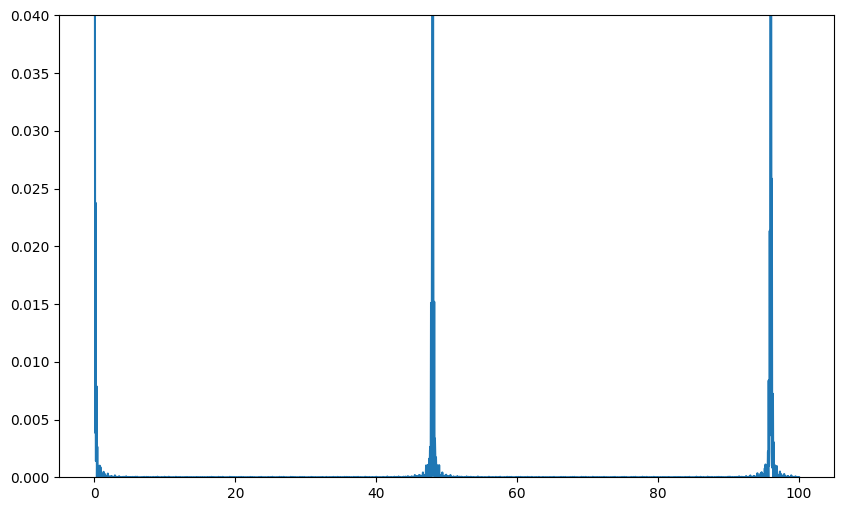

In [82]:
w_f = window_function(t=time, f_min=0, f_max=100)

fig = plt.figure(figsize=(10,6))
ax1 = fig.add_subplot()

ax1.plot(np.linspace(0,100, 2000), w_f)
ax1.set_ylim(0,0.04)

In [78]:
my_dict = {'f': np.linspace(0,100, 2000),
           'W(f)': w_f}
test = pd.DataFrame(data=my_dict)

test.sort_values(by='W(f)', ascending=False).head(10)

,f,W(f)
0,0.000000,1.000000
1919,95.997999,0.992640
960,48.024012,0.234044
959,47.973987,0.174590
1918,95.947974,0.078891
1,0.050025,0.067019
1920,96.048024,0.053724
961,48.074037,0.035008
958,47.923962,0.026415
1922,96.148074,0.025848


### Other Function